In [110]:
import pandas as pd
import string
import os
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS 
from keras_preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from numpy import array
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Flatten, Dense
from tensorflow.keras.optimizers import SGD
from keras.losses import binary_crossentropy
from keras.callbacks import ModelCheckpoint
import numpy as np

import argparse

In [24]:
TRAIN_DATASET = './datasets/imdb.csv'
tmp_dir = './tmp/'


In [3]:
df = pd.read_csv(TRAIN_DATASET)
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


positive    25000
negative    25000
Name: sentiment, dtype: int64


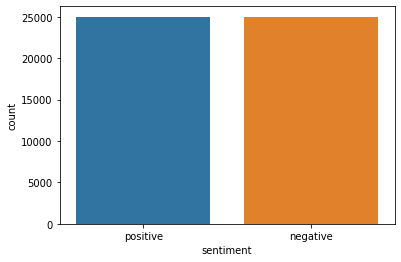

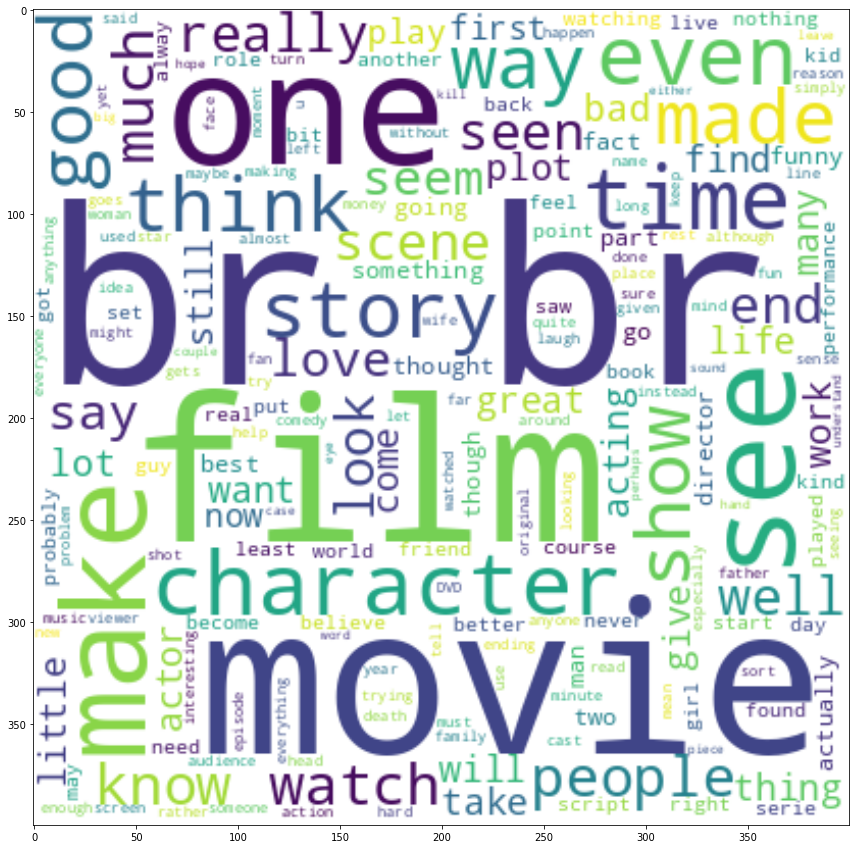

In [42]:
# A little EDA

# distribution of labels
print(df['sentiment'].value_counts())

sns.countplot(x='sentiment', data = df)
# word cloud

combined_text = ''
for index, row in df.iterrows():
    combined_text += " " + row['review']
    # print(row['review'])
    # break
wc = WordCloud(stopwords=STOPWORDS, background_color='white', height=400).generate(combined_text)
plt.figure(figsize=(15,15))
plt.imshow(wc, interpolation='bilinear')
plt.savefig("wordcloud.png")
plt.show()

In [8]:
text_sample = list()
text_sample.append(df['review'][0])
text_sample.append(df['review'][10])
text_sample.append(df['review'][100])
text_sample.append(df['review'][1000])
text_sample.append(df['review'][10000])

for sample in text_sample:
    print(sample)
    print("\n\n")

One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fac

### To remove
\<br/>



In [80]:
def process_text(text):
    #Clean and produce tokens
    text = text.lower()

    #remove <br />
    text = re.sub('(<|&lt;)br\s*\/*(>|&gt;)', '', text)

    #remove punctuations
    table = str.maketrans('','',string.punctuation)
    tokens = [token.translate(table) for token in text.split(" ")]

    #remove stop words and non-letter words
    tokens = [ word for word in tokens if word.isalpha() and word not in stopwords.words('english')]

    return tokens

if os.path.exists(tmp_dir) == False:
    cleaned_text = list()
    labels = list()
    for index, row in df.iterrows():
        cleaned_text.append(process_text(row['review']))
        labels.append(row['sentiment'])

    print('Cleaned text len = ', len(cleaned_text))
    print('Labels len = ',len(labels))

    if os.path.exists(tmp_dir) == False:
        os.mkdir(tmp_dir)

    with open('/'.join([tmp_dir, 'cleaned_dataset.csv']), 'w') as file:
        to_write = ""
        for text, label in zip(cleaned_text, labels):
            to_write += "{},{}\n".format(" ".join(text), label)
        file.write(to_write)
else:
    cleaned_text = list()
    labels = list()
    with open('/'.join([tmp_dir, 'cleaned_dataset.csv'])) as file:
        lines = file.readlines()
        for line in lines:
            cleaned_text.append(line.split(",")[0])
            labels.append(line.split(",")[1].strip())

    print('Cleaned text len = ', len(cleaned_text))
    print('Labels len = ',len(labels))

Cleaned text len =  50000
Labels len =  50000


In [ ]:
combined_text = ''
for text in cleaned_text:
    combined_text += " " + text

#Word cloud after dataset cleaning
new_wc = WordCloud(height=400, background_color='white').generate(combined_text)

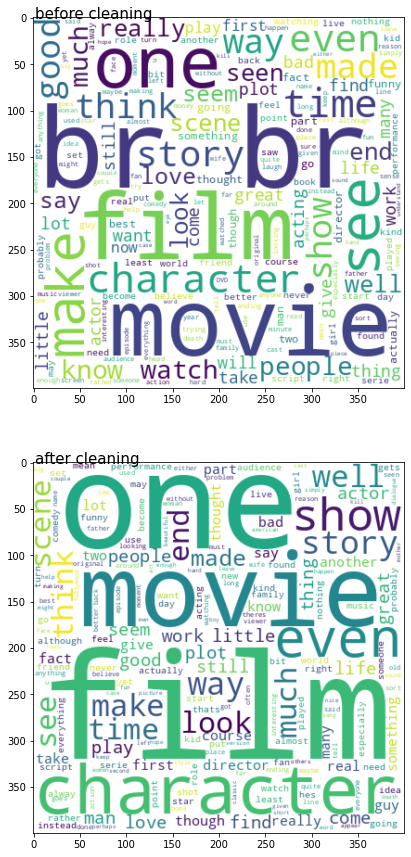

In [54]:
plt.rcParams['savefig.facecolor'] = 'white'
plt.figure(figsize=(15,15))
plt.subplot(211)
plt.text(1, 1, 'before cleaning',fontsize=15)
plt.imshow(wc, interpolation='bilinear')
plt.subplot(212)
plt.text(1, 1, 'after cleaning', fontsize = 15)
plt.imshow(new_wc, interpolation='bilinear')
plt.savefig('cleaned_wordcloud.png', bbox_inches = 'tight', dpi = 100)
plt.show()

In [58]:
def process_features(features, labels, tokenizer, maxlen, is_train = True):
    if is_train:
        tokenizer.fit_on_texts(features)
    encoded_dataset = tokenizer.texts_to_sequences(features)

    #pad sequences to the max length sequence
    x_train = pad_sequences(encoded_dataset, maxlen=maxlen, padding="post")
    y_train = array(labels)
    return x_train, y_train

In [86]:
tokenizer = Tokenizer()
maxlen_token = max([len(line.split(" ")) for line in cleaned_text])

X, y = process_features(cleaned_text, labels, tokenizer, maxlen_token, is_train=True)

labelencoder = LabelEncoder()
labelencoder.fit(y)
y= labelencoder.transform(y)

print("Max len token = ", maxlen_token)
print("x_train shape: ", X.shape)
print("y_train shape: ", y.shape)
print("x_train sample: ", X[0])
print("y_train sample: ", y[0])
print("label classes :", labelencoder.classes_)

Max len token =  1416
x_train shape:  (50000, 1416)
y_train shape:  (50000,)
x_train sample:  [   3 1788  931 ...    0    0    0]
y_train sample:  1
label classes : ['negative' 'positive']


In [82]:
#Save vocab to a file 
vocab_file = 'vocab.txt'

if os.path.exists(vocab_file) == False:
    print("{} not found. creating vocab from tokenizer".format(vocab_file))
    vocab = tokenizer.word_index
    with open(vocab_file, 'w') as file:
        to_write = ""
        for key, value in vocab.items():
            to_write += '{}:{}\n'.format(key, value)
        file.write(to_write)
else:
    with open(vocab_file, 'r') as file:
        print("{} found. Reading to vocab object".format(vocab_file))
        vocab = dict()
        lines = file.readlines()
        for line in lines:
            (key, value) = line.split(":") 
            vocab[key] = value

vocab.txt found. Reading to vocab object
Vocab keys count  213389


In [87]:
# # print(vocab)
# print('Vocab keys count ', len(vocab))
# x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state = 42)

# print("x_train shape ", x_train.shape)
# print("y_train shape ", y_train.shape)
# print("x_valid shape ", x_valid.shape)
# print("y_valid shape ", y_valid.shape)

Vocab keys count  213389
x_train shape  (40000, 1416)
y_train shape  (40000,)
x_valid shape  (10000, 1416)
y_valid shape  (10000,)


### Define models

In [108]:
def basic_model(args):
    model = Sequential()
    model.add(Embedding(args.vocab_size + 1, 100, input_length=args.maxlen_token))
    model.add(Conv1D(filters = 32., kernel_size=8, activation='relu'))
    model.add(MaxPooling1D())
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    return model


def compile_model(model, args):
    model.compile(loss=args.loss, 
    optimizer = SGD(learning_rate=args.learning_rate,momentum=args.momentum),
     metrics=['accuracy'])
    return model

def train(model, args, checkpoint = True, checkpoint_path = None):
    if checkpoint:
        if checkpoint_path == None:
            checkpoint_path = './tmp/checkpoint'
    
        if os.path.exists(checkpoint_path):
            print("Loaded weight checkpoint in {}".format(checkpoint_path))
            model.load_weights(checkpoint_path)
    
    model_checkpoint = ModelCheckpoint(
        filepath = checkpoint_path,
        save_weights_only=True,
        monitor = 'val_accuracy',
        mode = 'max',
        save_best_only= True
    )

    if checkpoint:
        return model.fit(
            args.X,
            args.y,
            epochs = args.epochs,
            verbose = args.verbose,
            validation_split = 0.2,
            callbacks = [model_checkpoint]
        )
    else:
        return model.fit(
            args.X,
            args.y,
            epochs = args.epochs,
            verbose = args.verbose,
            validation_split = 0.2,
        )


def summarize_diagnostic(history, path = '', description = None):
    plt.figure(figsize=(10,10))
    plt.figtext(0, 1, description, fontsize=15)
    plt.subplot(211)
    plt.title("Loss")
    plt.plot(history.history['loss'], color="blue", label="train loss")
    plt.plot(history.history['val_loss'], color="red", label="validation loss")
    plt.legend()
    plt.subplot(212)
    plt.title("Accuracy")
    plt.plot(history.history['accuracy'], color="blue", label="train accuracy")
    plt.plot(history.history['val_accuracy'], color="red", label="validation accuracy")
    plt.legend()
    if(path!= ''):
        plt.rcParams['savefig.facecolor'] = 'white'
        plt.savefig(path, dpi = 100, bbox_inches = 'tight')

In [104]:
args = argparse.Namespace()

args.epochs = 20
args.verbose = 1
args.loss = 'binary_crossentropy'
args.maxlen_token = maxlen_token
args.learning_rate = 0.001
args.momentum = 0.9
args.vocab_size = len(vocab)
args.X = X 
args.y = y 

In [101]:
model = basic_model(args)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1416, 100)         21339000  
                                                                 
 conv1d_1 (Conv1D)           (None, 1409, 32)          25632     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 704, 32)          0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 22528)             0         
                                                                 
 dense_2 (Dense)             (None, 100)               2252900   
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                      

In [105]:
model = compile_model(model, args)
history = train(model, args)

Epoch 1/20


2022-04-26 19:01:02.901704: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8400
2022-04-26 19:01:04.770842: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1250/1250 [==============================] - 10s 4ms/step - loss: 0.6932 - accuracy: 0.5016 - val_loss: 0.6928 - val_accuracy: 0.5179
Epoch 2/20
1250/1250 [==============================] - 5s 4ms/step - loss: 0.6927 - accuracy: 0.5128 - val_loss: 0.6926 - val_accuracy: 0.5036
Epoch 3/20
1250/1250 [==============================] - 6s 4ms/step - loss: 0.6920 - accuracy: 0.5199 - val_loss: 0.6923 - val_accuracy: 0.5023
Epoch 4/20
1250/1250 [==============================] - 5s 4ms/step - loss: 0.6910 - accuracy: 0.5282 - val_loss: 0.6908 - val_accuracy: 0.5423
Epoch 5/20
1250/1250 [==============================] - 5s 4ms/step - loss: 0.6892 - accuracy: 0.5432 - val_loss: 0.6881 - val_accuracy: 0.5404
Epoch 6/20
1250/1250 [==============================] - 5s 4ms/step - loss: 0.6838 - accuracy: 0.5767 - val_loss: 0.6792 - val_accuracy: 0.5665
Epoch 7/20
1250/1250 [==============================] - 6s 4ms/step - loss: 0.6601 - accuracy: 0.6421 - val_loss: 0.6314 - val_accuracy: 0.6596
Ep

    RESULTS:    model config: VGG16_trainable
    learning_rate: 0.001
    momentum: 0.9
    epochs: 20
    valid_accuracy: 0.8819000124931335
    valid_loss: 0.29395201802253723



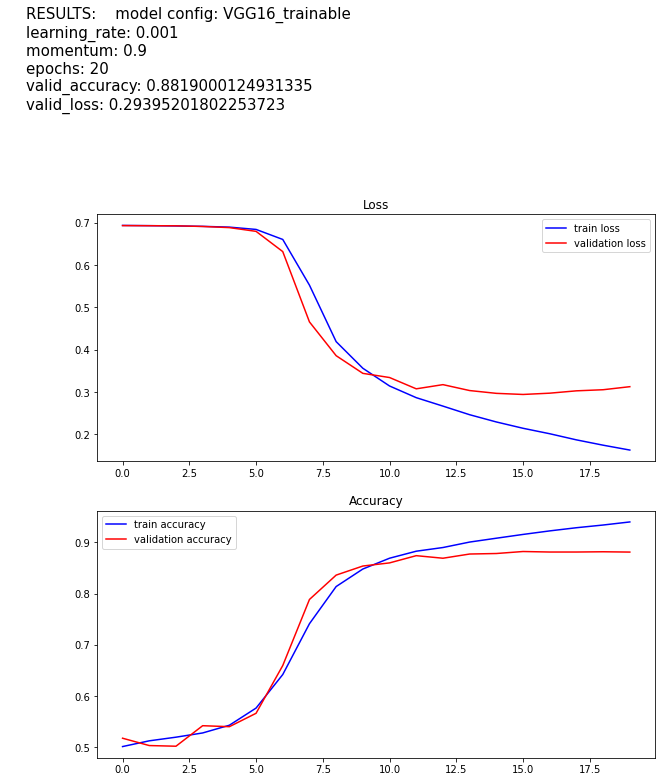

In [111]:
description_text = "\
    RESULTS:\
    model config: {}\n\
    learning_rate: {}\n\
    momentum: {}\n\
    epochs: {}\n\
    valid_accuracy: {}\n\
    valid_loss: {}\n".format("VGG16_trainable", 
    args.learning_rate, 
    args.momentum,
    args.epochs,
    np.max(history.history['val_accuracy']),
    np.min(history.history['val_loss'])
    )

print(description_text)

summarize_diagnostic(history, 'base_model.png', description_text)